```{admonition} Information
__Section__: Prediction from all data vs. split dataset  
__Goal__: Understand how splitting the dataset can give better predictions and when to do that.  
__Time needed__: 30 min  
__Prerequisites__: AIS data, basics about machine learning
```

# Prediction from all data vs. split dataset

Your customer would like to have a model that can predict the mean speed of a vessel based on its type and size. As we will see together, this task is not the easiest with the dataset we have, as it contains a lot of different ships with different missions at sea.

In this section, we will explore how it can be useful to be able to split the available data to build a more performant model, depending on what we want to achieve.

We will use the static dataset for this prediction.

In [2]:
%run 1-functions.ipynb # this line runs the other functions we will use later on the page

import pandas as pd

static_data = pd.read_csv('./static_data.csv')

## Prediction using the whole dataset

We will start by predicting the ``MeanSOG`` using the predictive attributes ``VesselType``, ``Length``, ``Width`` and ``Draft``.

```{toggle} Advanced level
Let's add the attribute names into the variables ``x`` and ``y``.
```

In [3]:
x = ['VesselType', 'Length', 'Width', 'Draft']
y = ['MeanSOG']

Now we can use the regression function to make predictions.

In [6]:
from sklearn.metrics import mean_absolute_error

predictions, y_test = knn_regression(static_data, x, y)
print('MAE: ' + str(mean_absolute_error(predictions, y_test)))

MAE: 1.2733923934326852


To better undestand if the MAE is good, as it depends on the scale of the predicted attribute, we need to know its distribution, the max and min values:

In [7]:
static_data['MeanSOG'].describe()

count    1520.000000
mean        1.034825
std         2.936439
min        -0.100000
25%         0.000000
50%         0.012633
75%         0.072000
max        20.360811
Name: MeanSOG, dtype: float64

The mean value of ``MeanSOG`` is ``1.03`` knots and its standard deviation is ``2.94``, so we can imagine that our MAE of ``1.27`` is not a very good performance. To be sure, let's build a baseline model that will predict always the mean value of ``MeanSOG``.

```{toggle} Advanced level
For that, we use the function [baseline_reg()](./../appendix/A-1-2-algorithms.html):
```

In [4]:
from sklearn.metrics import mean_absolute_error

pred_base, y_test_base = baseline_reg(static_data, x, y)
print('MAE: ' + str(mean_absolute_error(pred_base, y_test_base)))

MAE: 1.467831401836625


The baseline model gives a slightly worse performance. But if we come back to our regression model, we still consider it to be not satisfactory and we want to upgrade it. To try to understand why we get this performance, let's visually analyze the distribution of the attribute ``MeanSOG`` and the predictions made by the model.

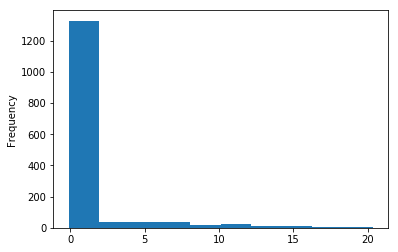

In [8]:
static_data['MeanSOG'].plot.hist()

First, we see that the dataset contains a lot of low values for the attribute ``MeanSOG``. Let's look at the predictions made:

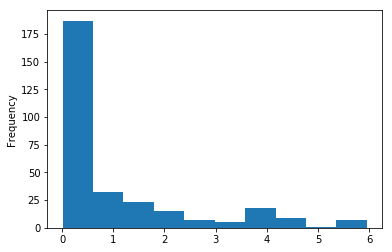

In [9]:
# We need to rearrange the list predictions to be able to use the function hist()
pred = []
for element in predictions:
    pred.append(element[0])
    
pd.Series(pred).plot.hist()

Let's compare this histogram with the one of the true labels (in the testing set):

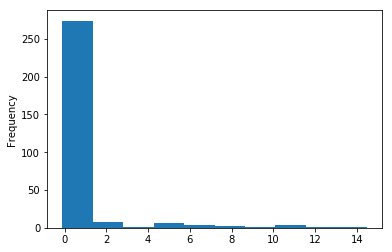

In [10]:
pd.Series(y_test['MeanSOG']).plot.hist()

We see that the model gives much more predictions of low value, but there is still a big difference between the predictions and the true labels. The model tends to predict higher values more often than it is the case in the test dataset.

How could we try to build a model that gives good predictions for the mean speed of ships with such an unbalanced dataset?

One solution could be to split the dataset between low speed ships and "normal" speed ships. When the customer wants to make a prediction, they should be able to tell if the ship they want to predict the speed of is mobile or not, and then be able to select the right model: for mobile or immobile ships. Let's have a look at this idea.

## Split the dataset

According to the distribution of the data we saw before, we can tell that most low values are under 1. So, let's split the dataset into mobile and immobile ships, taking the value 1 of ``MeanSOG`` for the threshold.

We will do the analysis on the mobile ships only, as it doesn't seem interesting to predict the mean speed of an immobile ship.

```{toggle} Advanced level
For the selection of the data, we use the function [loc()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html).
```

In [6]:
mobile = static_data.loc[static_data['MeanSOG'] >= 1]

Now let's try to make predictions for the new dataset and analyze the performance.

Here is the MAE of the prediction for the mobile ships:

In [12]:
# Prediction for mobile ships

predictions2, y_test2 = knn_regression(mobile, x, y)
print('MAE: ' + str(mean_absolute_error(predictions2, y_test2)))

MAE: 2.8503720152323386


Here is the mean value of the attribute ``MeanSOG`` in this dataset:

In [13]:
mobile['MeanSOG'].mean()

7.006852415734686

Here is the result of the baseline  model on the same dataset:

In [7]:
# Baseline

pred_base2, y_test_base2 = baseline_reg(mobile, x, y)
print('MAE: ' + str(mean_absolute_error(pred_base2, y_test_base2)))

MAE: 4.374385077393023


Without looking at the histograms, we can already get an idea of the performance of the model.

## Compare the results

The model for mobile ships seems to be giving better results compared to the mean value of the dataset and the baseline model. Of course, the MAE in general is much higher than the one of the model with the whole dataset, but we saw that the model seemed to be only good for predicting the low values of ``MeanSOG``.

Let's check this out. We collect the values of the true labels and predictions for the mobile ships only, from the very first model we built (using the whole dataset).

The mean error on the mobile ships with this first model was:

In [14]:
pred = []
for element in predictions:
    pred.append(element[0])

# Create two lists to collect true labels with MeanSOG >= 1 and the corresponding predictions
pred_sup1 = []
y_test_sup1 = []

i = 0
for value in y_test['MeanSOG']:
    if value >= 1:
        y_test_sup1.append(value)
        pred_sup1.append(pred[i])
    i = i + 1
    
print('MAE' + str(mean_absolute_error(pred_sup1, y_test_sup1)))

3.950739471015331


The mean absolute error on the mobile ships with the first model is higher than the one we got with the new model when splitting the data. This is a good sign that splitting the data helped to create a better model for the moving ships.

To go further, we can have a look at the boxplots of the predictions of both models. This is another type of visualization of the data which can instantly inform us on the state of the prediction and the possible need to build several models for several cases. For more information about boxplot, see the [introduction page about graphs](./../introduction/0-3-graphs.html).

Boxplot of the predictions with the first model:

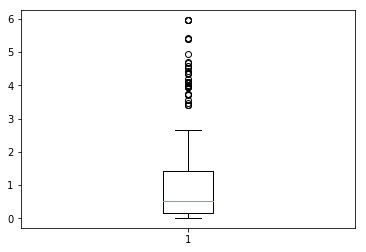

In [15]:
import matplotlib.pyplot as plt

# Boxplot of the predictions with the first model
plt.boxplot(predictions)
plt.show()

We can see with this boxplot that most predicted values are low, and the highest values are considered as outliers. Let's compare it with the boxplot of the predictions made by the second model:

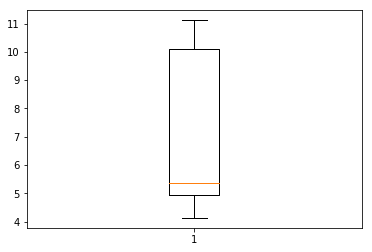

In [16]:
# Boxplot of the predictions with the second model
plt.boxplot(predictions2)
plt.show()

Here, the predictions are much more homogeneous. This seems more acceptable for a predictive model, as we want a model that can generalize on new data.

## Generalization

What this experiment taught us is that sometimes, the data used to build a model are too heterogeneous and should be split, if they could. In our case, it makes sense to split the data between mobile and immobile ships, as it is an easy feature to verify before using a model to predict the speed. Also, predicting the speed of a ship that is actually moving seems much more interesting than predicting the speed of a ship that doesn't move.

In general, it is important to check that the data used for training a model are a good representation of the environment in which the model will be in use later.

Also, in a case where we want to split the dataset, it is important to make sure that there is a way to figure out which model has to be used for any instance we want to classify. In our case, it is quite easy to tell an immobile ship appart from a mobile one, but there might be some more tricky cases.

## Quiz

In [1]:
from IPython.display import IFrame
IFrame("https://h5p.org/h5p/embed/761972", "694", "600")